In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fasterai.loss import *
from fasterai.models import *
from pathlib import Path
from itertools import repeat
torch.cuda.set_device(2)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
proj_id = 'bw2color'
wd=1e-7
keep_pct=0.1

## Model

##### TODO:  Also try making the loss/output based on "classification" like in Zhang et al.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).
##### TODO:  Try using higher res images (from FloydHub blog?)
##### TODO:  Try perceptual loss again....
##### TODO:  To convert real old photos, could force them to normal grayscale first.

In [4]:
class ImageModifierModel(nn.Module):
    @staticmethod
    def _res_block(nf):
        return ResSequential(
            [ConvBlock(nf, nf, actn=True, bn=False), 
             ConvBlock(nf, nf, actn=False, bn=False)], 0.1)
    
    @staticmethod
    def _generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut

    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
    
    def __init__(self, nf_up=64, nf_mid=256):
        super().__init__() 
        rn, lr_cut = ImageModifierModel._generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = nn.Sequential(*[UpSampleBlock(256, nf_up, 2), UpSampleBlock(nf_up,nf_up, 8)])  #256 in
        self.up2 = nn.Sequential(*[UpSampleBlock(128, nf_up, 2), UpSampleBlock(nf_up,nf_up, 4)])  #128 in
        self.up3 = nn.Sequential(*[UpSampleBlock(64,nf_up), UpSampleBlock(nf_up,nf_up, 2)])    #64 in
        self.up4 = UpSampleBlock(64, nf_up)   #64 in  
        
        mid_layers = []
        mid_layers += [ConvBlock(nf_up * 4,nf_mid, actn=False)]
        for i in range(8): mid_layers.append(ImageModifierModel._res_block(nf_mid))
        mid_layers += [nn.BatchNorm2d(nf_mid), ConvBlock(nf_mid, 3, ks=1, actn=False, bn=False)]
        self.upconv = nn.Sequential(*mid_layers)
             
        out_layers = []
        out_layers += [ConvBlock(6, 3, ks=1, actn=False, bn=False)]
        self.out = nn.Sequential(*out_layers)
        
    def forward(self, x): 
        self.rn(x)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        x5 = self.upconv(torch.cat([x1, x2, x3, x4], dim=1))
        return F.tanh(self.out(torch.cat([x, x5], dim=1)))

In [5]:
class ImageModifierModelWrapper():
    def __init__(self):
        self.model = to_gpu(ImageModifierModel())
        self.name = 'imodwrapper'

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [self.model.lr_cut]))
        return lgs + [children(self.model)[1:]]

## Training

In [6]:
def train(lrs, session_num: int, cycle_len=2, use_clr_beta=(20,10,0.95,0.85)):
    if session_num > 0:
        learn.load(proj_id + '_2_' + str(session_num - 1))
    learn.fit(lrs, 1, cycle_len=cycle_len, wds=wd, use_clr_beta=use_clr_beta)
    learn.save(proj_id + '_2_' + str(session_num))

In [7]:
md = get_matched_image_model_data(image_size=64, batch_size=24, root_data_path=DATA_PATH, train_root_path=TRAIN_SOURCE_PATH, proj_id=proj_id, keep_pct=keep_pct)

In [8]:
#m = SrResnet(64, 1)
#imod = ImageModifierModelWrapper()
imod = ImageModifierModelWrapper()
learn = ConvLearner(md, imod)
learn.metrics = []
learn.opt_fn=optim.Adam
learn.crit = F.mse_loss #(turns sepia/blurry)
#learn.crit = FeatureLoss()
#learn.crit = F.l1_loss
#learn.models.model = nn.DataParallel(learn.models.model, [0,1,2,3])

/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)
/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)
/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)
/media/jason/Projects/Deep Learning/Deep Learning Projects/Jupyter Experiments/1_BlackWhiteToColor/fasterai/models.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  subkernel = init(subkernel)
/media/jason/Projects/Deep L

In [9]:
learn.freeze_to(1)

In [10]:
learn.lr_find(1e-3, 1e2, wds=wd, linear=False)

 12%|█▏        | 569/4801 [03:37<26:58,  2.62it/s, loss=0.159]

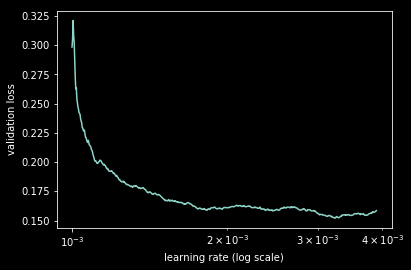

In [11]:
learn.sched.plot(n_skip=0, n_skip_end=0)

In [14]:
lr=1e-3
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
train(lr,0,cycle_len=2, use_clr_beta=(5,8,0.95,0.85)) 
visualize_image_gen_model(md, imod.model, 220, 8, immediate_display=False)

epoch      trn_loss   val_loss   
    0      0.139739   0.089336  
  7%|▋         | 347/4801 [02:27<31:36,  2.35it/s, loss=0.137]

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
train(lrs/4,1,cycle_len=2,use_clr_beta=(20,10,0.95,0.85)) 
visualize_image_gen_model(md, imod.model, 220, 8, immediate_display=False)

## 128 x 128

In [ ]:
learn.freeze_to(1)

In [ ]:
md = get_matched_image_model_data(image_size=128, batch_size=64, root_data_path=DATA_PATH, train_root_path=TRAIN_SOURCE_PATH, proj_id=proj_id, keep_pct=keep_pct)
learn.set_data(md)

In [ ]:
lr=lr/8
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
train(lrs,2,cycle_len=2, use_clr_beta=(5,5,0.95,0.85)) 
visualize_image_gen_model(220,8, immediate_display=False)

In [ ]:
visualize_image_gen_model(md, imod.model, 40, 64, figsize=(20,160), immediate_display=False)

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
train(lrs/4,3,cycle_len=2, use_clr_beta=(20,8,0.95,0.85)) 
visualize_image_gen_model(220,8, immediate_display=False)

## 224 x 224

In [ ]:
learn.freeze_to(1)

In [ ]:
md = get_matched_image_model_data(image_size=224, batch_size=16, root_data_path=DATA_PATH, train_root_path=TRAIN_SOURCE_PATH, proj_id=proj_id, keep_pct=keep_pct)
learn.set_data(md)

In [ ]:
learn.lr_find(1e-4, 1e1, wds=wd, linear=False)

In [ ]:
learn.sched.plot(n_skip=0, n_skip_end=0)

In [ ]:
#lr=lr/8
lr =1e-3
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
visualize_image_gen_model(md, imod.model, 40, 64, figsize=(20,160), immediate_display=False)

In [ ]:
train(lrs/10,4,cycle_len=2, use_clr_beta=(20,8,0.95,0.85)) 
visualize_image_gen_model(220,8, immediate_display=False)